In [1]:
import datetime
import numpy as np
import os
import pandas as pd
import shutil
import urllib.request
import zipfile
import time
import math
import matplotlib.pyplot as plt
from functools import wraps
from math import trunc
from sklearn.metrics import mean_squared_error
from numba import jit, cuda

In [2]:
# VARIANTS object defines data configurations for different file sizes.
# Each key represents the data size (e.g., "100k" for 100 thousand).
VARIANTS = {
    "100k": {"filename": "u.data", "sep": "\t"},
    "1m": {"filename": "ratings.dat", "sep": r"::"},
    "20m": {"filename": "ratings.csv", "sep": ","},
    "32m": {"filename": "ratings.csv", "sep": ","},
}

In [3]:
# Define the chosen data variant (e.g., "100k", "1m", "20m" or "32m")
variant = "20m"

In [4]:
# Check if the chosen variant is a valid key in the VARIANTS object
if variant not in VARIANTS:
    # If not valid, raise an error
    raise ValueError(
        f"Invalid variant: {variant}. Valid options are {list(VARIANTS.keys())}"
    )

In [5]:
# Construct the URL for downloading the data based on the chosen variant
url = f"http://files.grouplens.org/datasets/movielens/ml-{variant}.zip"

In [6]:
# Extract information from the VARIANTS object for the chosen variant
variant_info = VARIANTS[variant]

# Destructure filename property from the variant information
filename = variant_info["filename"]

# Construct the directory name based on the variant
dirname = f"ml-{variant}"

# Construct the path to the downloaded zip file
zip_path = os.path.join(dirname + ".zip")

# NHO REMOVE CELL BEN DUOI

In [7]:
# proxy_url = "http://26.26.26.1:10809"

# proxy_support = urllib.request.ProxyHandler({"http": proxy_url})

# opener = urllib.request.build_opener(proxy_support)

# urllib.request.install_opener(opener)

In [8]:
# # Download the data from the URL and save it to the zip_path
# with urllib.request.urlopen(url) as r, open(zip_path, "wb") as f:
#     # Copy the downloaded data from the response to the file
#     shutil.copyfileobj(r, f)

In [9]:
# # Extract the data from the downloaded zip file
# with zipfile.ZipFile(zip_path, "r") as zf:
#     # Extract all files from the zip archive to the current directory
#     zf.extractall()

In [10]:
# # Remove zip file after extraction (optional)
# os.remove(zip_path)

In [11]:
# Construct the path to the CSV file
csv_path = os.path.join(dirname, filename)

# Define the column names for the data
names = ["u_id", "i_id", "rating", "timestamp"]

# Define data type for each column
dtype = {"u_id": np.uint32, "i_id": np.uint32, "rating": np.float64}

In [12]:
# Read the CSV data into a Pandas DataFrame
df = pd.read_csv(
    csv_path,
    names=names,
    dtype=dtype,
    header=0,
    sep=VARIANTS[variant]["sep"],
)

In [13]:
# Drop the "timestamp" column from the DataFrame
df.drop("timestamp", inplace=True, axis=1)

# Sort the DataFrame by the "u_id" column (assuming user IDs)
df.sort_values(by="u_id", inplace=True)

# Reset the index after sorting (optional, keeps row numbers aligned with data)
df.reset_index(drop=True, inplace=True)

In [14]:
# Randomly sample 80% for training set
train = df.sample(frac=0.8, random_state=7)

# Sample 50% from remaining for validation
val = df.drop(train.index.tolist()).sample(frac=0.5, random_state=8)

# Remaining data becomes test set
test = df.drop(train.index.tolist()).drop(val.index.tolist())

In [15]:
@jit(cache=True)
def shuffle(X):
    np.random.shuffle(X)
    return X

C:\Users\DUY\AppData\Local\Temp\ipykernel_23892\3120321745.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(cache=True)


In [16]:
@jit(cache=True)
def initialization(n_users, n_items, n_factors):
    # Initialize user biases with zeros (n_users length)
    bu = np.zeros(n_users)

    # Initialize item biases with zeros (n_items length)
    bi = np.zeros(n_items)

    # Random user factors (normal distribution, mean 0, std 0.1)
    pu = np.random.normal(0, 0.1, (n_users, n_factors))

    # Random item factors (normal distribution, mean 0, std 0.1)
    qi = np.random.normal(0, 0.1, (n_items, n_factors))

    return bu, bi, pu, qi

C:\Users\DUY\AppData\Local\Temp\ipykernel_23892\660544247.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(cache=True)


In [17]:
@jit(cache=True)
def run_epoch_cpu(X, bu, bi, pu, qi, global_mean, n_factors, lr, reg):
    # Loop through each rating in the data matrix X
    for i in range(X.shape[0]):
        # Extract user ID, item ID, and rating from current row
        user, item, rating = int(X[i, 0]), int(X[i, 1]), X[i, 2]

        # Predict current rating
        pred = global_mean + bu[user] + bi[item]
        for factor in range(n_factors):
            pred += pu[user, factor] * qi[item, factor]

        # Calculate the error between predicted and actual rating
        err = rating - pred

        # Update user and item biases with learning rate (lr) and regularization (reg)
        bu[user] += lr * (err - reg * bu[user])
        bi[item] += lr * (err - reg * bi[item])

        # Update user and item latent factors for all factors (n_factors)
        for factor in range(n_factors):
            puf = pu[user, factor]
            qif = qi[item, factor]

            pu[user, factor] += lr * (err * qif - reg * puf)
            qi[item, factor] += lr * (err * puf - reg * qif)

    return bu, bi, pu, qi


C:\Users\DUY\AppData\Local\Temp\ipykernel_23892\533422370.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(cache=True)


In [18]:
@cuda.jit
def run_epoch_gpu(X, bu, bi, pu, qi, global_mean, n_factors, lr, reg):
    c = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    # Loop through each rating in the data matrix X
    if c < X.shape[0]:
        # Extract user ID, item ID, and rating from current row
        user, item, rating = int(X[c, 0]), int(X[c, 1]), X[c, 2]

        # Predict current rating
        pred = global_mean + bu[user] + bi[item]
        for factor in range(n_factors):
            pred += pu[user, factor] * qi[item, factor]

        # Calculate the error between predicted and actual rating
        err = rating - pred

        # Update user and item biases with learning rate (lr) and regularization (reg)
        bu[user] += lr * (err - reg * bu[user])
        bi[item] += lr * (err - reg * bi[item])

        # Update user and item latent factors for all factors (n_factors)
        for factor in range(n_factors):
            puf = pu[user, factor]
            qif = qi[item, factor]

            pu[user, factor] += lr * (err * qif - reg * puf)
            qi[item, factor] += lr * (err * puf - reg * qif)


In [19]:
@jit(cache=True)
def compute_val_metrics(X_val, bu, bi, pu, qi, global_mean, n_factors):
    residuals = []

    for i in range(X_val.shape[0]):
        user, item, rating = int(X_val[i, 0]), int(X_val[i, 1]), X_val[i, 2]

        pred = global_mean

        if user > -1:
            pred += bu[user]

        if item > -1:
            pred += bi[item]

        if (user > -1) and (item > -1):
            for factor in range(n_factors):
                pred += pu[user, factor] * qi[item, factor]

        residuals.append(rating - pred)

    residuals = np.array(residuals)
    loss = np.square(residuals).mean()
    rmse = np.sqrt(loss)
    mae = np.absolute(residuals).mean()

    return loss, rmse, mae

C:\Users\DUY\AppData\Local\Temp\ipykernel_23892\284637194.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(cache=True)


In [20]:
class bcolors:
    GREEN = "\033[92m"
    YELLOW = "\033[93m"
    RED = "\033[91m"
    ENDC = "\033[0m"

In [21]:
class SVD:
    def __init__(
        self,
        lr=0.005,
        reg=0.02,
        n_epochs=20,
        n_factors=100,
        early_stopping=True,
        min_delta=0.001,
        min_rating=1,
        max_rating=5,
        parallel=True
    ):

        self.lr = lr
        self.reg = reg
        self.n_epochs = n_epochs
        self.n_factors = n_factors
        self.early_stopping = early_stopping
        self.shuffle = shuffle
        self.min_delta = min_delta
        self.min_rating = min_rating
        self.max_rating = max_rating
        self.parallel = parallel
        self.log = []

    def fit(self, X, X_val=None):
        # Preprocess the training data
        X = self.preprocess_data(X)

        # Check if validation data is provided
        if X_val is not None:
            # Preprocess the validation data
            X_val = self.preprocess_data(X_val, train=False)
            # Initialize metrics for evaluation
            self.init_metrics()

        # Calculate the global mean of the rating feature
        self.global_mean_ = np.mean(X[:, 2])

        # Run the Stochastic Gradient Descent (SGD) algorithm
        self.run_sgd(X, X_val)

        return self

    def preprocess_data(self, X, train=True):
        # Copy the data to avoid modifying the original DataFrame
        X = X.copy()

        # Mappings are only needed during training
        if train:
            # Create unique mappings for user and item IDs (if training)
            user_ids = X["u_id"].unique().tolist()
            item_ids = X["i_id"].unique().tolist()

            n_users = len(user_ids)
            n_items = len(item_ids)

            user_idx = range(n_users)
            item_idx = range(n_items)

            self.user_mapping_ = dict(zip(user_ids, user_idx))
            self.item_mapping_ = dict(zip(item_ids, item_idx))

        # Replace user and item IDs with their corresponding indices in the mappings
        X["u_id"] = X["u_id"].map(self.user_mapping_)
        X["i_id"] = X["i_id"].map(self.item_mapping_)

        # Tag unseen users/items in validation data with -1 (for handling unknown entries)
        X.fillna(-1, inplace=True)

        X["u_id"] = X["u_id"].astype(np.int32)
        X["i_id"] = X["i_id"].astype(np.int32)

        return X[["u_id", "i_id", "rating"]].values

    def init_metrics(self):
        # Initialize empty metrics array with zeros
        metrics = np.zeros((self.n_epochs, 3), dtype=float)

        # Create a pandas DataFrame from the metrics array
        self.metrics_ = pd.DataFrame(metrics, columns=["Loss", "RMSE", "MAE"])

    def run_sgd(self, X, X_val):
        # Get number of unique users
        n_users = len(np.unique(X[:, 0]))

        # Get number of unique items
        n_items = len(np.unique(X[:, 1]))

        # Initialize model parameters
        bu, bi, pu, qi = initialization(n_users, n_items, self.n_factors)

        # Run SGD for specified number of epochs
        for epoch_ix in range(self.n_epochs):
            start = self.on_epoch_begin(epoch_ix)

            if not self.parallel:
              X = shuffle(X)

              # Update model parameters using run_epoch function
              run_epoch_cpu(
                X, bu, bi, pu, qi, self.global_mean_, self.n_factors, self.lr, self.reg
              )
            else:
              block_size = 32
              grid_size = math.ceil(X.shape[0] / block_size)

              # Update model parameters using run_epoch function
              run_epoch_gpu[grid_size, block_size](
                  X, bu, bi, pu, qi, self.global_mean_, self.n_factors, self.lr, self.reg
              )

            if X_val is not None:
                # Compute validation metrics if validation data provided
                self.metrics_.loc[epoch_ix, :] = compute_val_metrics(
                    X_val, bu, bi, pu, qi, self.global_mean_, self.n_factors
                )
                self.on_epoch_end(
                    start,
                    self.metrics_.loc[epoch_ix, "Loss"],
                    self.metrics_.loc[epoch_ix, "RMSE"],
                    self.metrics_.loc[epoch_ix, "MAE"],
                )

                self.log.append(self.metrics_.loc[epoch_ix, "RMSE"])

                if self.early_stopping:
                    val_rmse = self.metrics_["RMSE"].tolist()
                    if self.check_early_stopping(val_rmse, epoch_ix, self.min_delta):
                        break

            else:
                self.on_epoch_end(start)

        # Update internal model parameters with learned values
        self.bu_ = bu
        self.bi_ = bi
        self.pu_ = pu
        self.qi_ = qi

    def predict(self, X, clip=True):
        # Generate predictions for each user-item pair in X
        return [
            self.predict_pair(u_id, i_id, clip)
            for u_id, i_id in zip(X["u_id"], X["i_id"])
        ]

    def predict_pair(self, u_id, i_id, clip=True):
        # Initialize flags indicating if user and item are known
        user_known, item_known = False, False

        # Start prediction with global mean rating
        pred = self.global_mean_

        # Check if user ID exists in user mapping
        if u_id in self.user_mapping_:
            user_known = True
            # Get user index
            u_ix = self.user_mapping_[u_id]
            # Add user bias
            pred += self.bu_[u_ix]

        # Check if item ID exists in item mapping
        if i_id in self.item_mapping_:
            item_known = True
            # Get user index
            i_ix = self.item_mapping_[i_id]
            # Add user bias
            pred += self.bi_[i_ix]

        # If both user and item are known, add user-item interaction component
        if user_known and item_known:
            pred += np.dot(self.pu_[u_ix], self.qi_[i_ix])

        # Clip the predicted rating to the defined range (if clip is True)
        if clip:
            pred = self.max_rating if pred > self.max_rating else pred
            pred = self.min_rating if pred < self.min_rating else pred

        return pred

    def check_early_stopping(self, val_rmse, epoch_idx, min_delta):
        if epoch_idx > 0:
            # Check if validation RMSE has worsened by more than min_delta
            if val_rmse[epoch_idx] + min_delta > val_rmse[epoch_idx - 1]:
                # Update metrics DataFrame up to the current epoch
                self.metrics_ = self.metrics_.loc[: (epoch_idx + 1), :]
                return True
        return False

    def on_epoch_begin(self, epoch_ix):
        start = time.time()
        end = "  | " if epoch_ix < 9 else " | "
        print(
            f"{bcolors.YELLOW}[EPOCH]:{bcolors.ENDC} {epoch_ix + 1}/{self.n_epochs}",
            end=end,
        )

        return start

    def on_epoch_end(self, start, val_loss=None, val_rmse=None, val_mae=None):
        end = time.time()

        if val_loss is not None:
            print(f"[VAL_LOSS]: {val_loss:.2f}", end=" - ")
            print(f"[VAL_RMSE]: {val_rmse:.2f}", end=" - ")
            print(f"[VAL_MAE]: {val_mae:.2f}", end=" | ")

        print(f"{bcolors.GREEN}[TIME]:{bcolors.ENDC} {end - start:.2f} s")

In [22]:
svd = SVD(
    lr=0.001,
    reg=0.005,
    n_epochs=50,
    n_factors=25,
    early_stopping=True,
    min_rating=1,
    max_rating=5,
    parallel=True
)

start = time.time()
svd.fit(X=train, X_val=val)
end = time.time()

print(f"\n{bcolors.RED}[PROCESSING TIME]:{bcolors.ENDC} {end - start:.2f} s")

[EPOCH]: 1/50  | 

c:\Python311\Lib\site-packages\numba\cuda\cudadrv\devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


[VAL_LOSS]: 0.84 - [VAL_RMSE]: 0.92 - [VAL_MAE]: 0.71 | [TIME]: 2.77 s
[EPOCH]: 2/50  | [VAL_LOSS]: 0.81 - [VAL_RMSE]: 0.90 - [VAL_MAE]: 0.69 | [TIME]: 2.08 s
[EPOCH]: 3/50  | [VAL_LOSS]: 0.79 - [VAL_RMSE]: 0.89 - [VAL_MAE]: 0.69 | [TIME]: 2.07 s
[EPOCH]: 4/50  | [VAL_LOSS]: 0.78 - [VAL_RMSE]: 0.88 - [VAL_MAE]: 0.68 | [TIME]: 2.10 s
[EPOCH]: 5/50  | [VAL_LOSS]: 0.77 - [VAL_RMSE]: 0.88 - [VAL_MAE]: 0.68 | [TIME]: 2.09 s
[EPOCH]: 6/50  | [VAL_LOSS]: 0.76 - [VAL_RMSE]: 0.87 - [VAL_MAE]: 0.67 | [TIME]: 2.09 s
[EPOCH]: 7/50  | [VAL_LOSS]: 0.76 - [VAL_RMSE]: 0.87 - [VAL_MAE]: 0.67 | [TIME]: 2.07 s
[EPOCH]: 8/50  | [VAL_LOSS]: 0.76 - [VAL_RMSE]: 0.87 - [VAL_MAE]: 0.67 | [TIME]: 2.04 s
[EPOCH]: 9/50  | [VAL_LOSS]: 0.75 - [VAL_RMSE]: 0.87 - [VAL_MAE]: 0.67 | [TIME]: 2.05 s
[EPOCH]: 10/50 | [VAL_LOSS]: 0.75 - [VAL_RMSE]: 0.87 - [VAL_MAE]: 0.67 | [TIME]: 2.06 s
[EPOCH]: 11/50 | [VAL_LOSS]: 0.75 - [VAL_RMSE]: 0.87 - [VAL_MAE]: 0.67 | [TIME]: 2.09 s
[EPOCH]: 12/50 | [VAL_LOSS]: 0.75 - [VAL_RMSE]: 0

In [23]:
pred = svd.predict(test)

In [24]:
rmse = mean_squared_error(test["rating"], pred, squared = False)
print(f"\n{bcolors.RED}[TEST RMSE]:{bcolors.ENDC} {rmse:.2f}")


[TEST RMSE]: 0.80


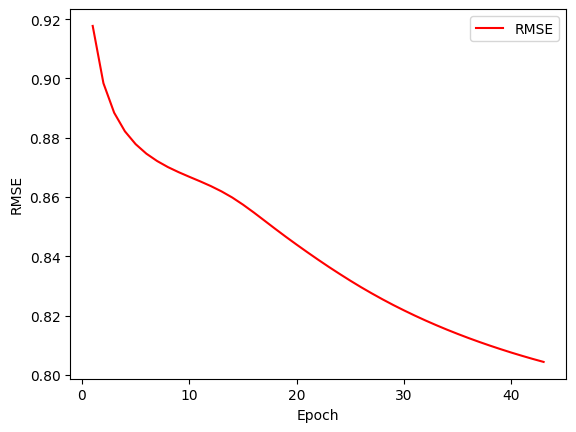

In [25]:
# Create epoch values
epochs = np.arange(1, len(svd.log) + 1)

# Plot the data
plt.plot(epochs, svd.log, color='r', label='RMSE')

# Customize x and y labels
plt.xlabel("Epoch")
plt.ylabel("RMSE")

# Add a legend
plt.legend()

# Show the plot
plt.show()

## So sánh Runtime với việc dùng Thư viện Surprise:

In [38]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [39]:
%%time

reader = Reader(rating_scale=(1, 5))

trainset = Dataset.load_from_df(train[['u_id', 'i_id', 'rating']],
                               reader=reader).build_full_trainset()

testset = Dataset.load_from_df(test[['u_id', 'i_id', 'rating']], reader=reader)
testset = testset.construct_testset(testset.raw_ratings)

CPU times: total: 19.8 s
Wall time: 30.4 s


In [40]:
start = time.time()
svd = SVD(lr_all=.001, reg_all=0.005, n_epochs=46, n_factors=15, verbose=True)
svd.fit(trainset)
end = time.time()
print(f"\n{bcolors.RED}[PROCESSING TIME]:{bcolors.ENDC} {end - start:.2f} s")

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45

[PROCESSING TIME]: 412.95 s


In [41]:
%%time

pred = svd.test(testset)
y_true = [p.r_ui for p in pred]
y_hat = [p.est for p in pred]

rmse = mean_squared_error(y_true, y_hat, squared = False)
mae = mean_absolute_error(y_true, y_hat)
print(f"\n{bcolors.RED}[TEST RMSE]:{bcolors.ENDC} {rmse:.2f}")
print(f"\n{bcolors.RED}[TEST MAE]:{bcolors.ENDC} {mae:.2f}")
print()


[TEST RMSE]: 0.80

[TEST MAE]: 0.61

CPU times: total: 9.31 s
Wall time: 16.2 s
